## This version: 61 procedures

### Load Order_Procedure from BQ

In [1]:
# example: read from BigQuery chart to numpy
from google.cloud import bigquery
from google.cloud.bigquery import dbapi;
import numpy as np
import pandas as pd



client = bigquery.Client("som-nero-phi-jonc101"); # Project identifier
conn = dbapi.connect(client);
cursor = conn.cursor();
query = "select * from `som-nero-phi-jonc101.Clinical_Collaborative_Filtering.pc_proc`"; # Example dataset table


# to DataFrame

df_all = (
    client.query(query)
    .result()
    .to_dataframe()
)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
N_proc = 20
df_n = df_all[['PC_enc', 'proc_name']]
temp_df = df_n.groupby(['proc_name']).apply(len).reset_index().rename(columns={'proc_name':'proc_name', 0:'num'}) #, as_index=False  
T = temp_df.sort_values('num',ascending=False).head(N_proc)['proc_name'].to_numpy()
for i in range(N_proc):
    print(T[i])



REFERRAL TO ENDOCRINE CLINIC
REFERRAL TO ENDOCRINOLOGY
METABOLIC PANEL, COMPREHENSIVE
DISCHARGE DIET
FOLLOW UP INSTRUCTIONS
TSH
PHYSICAL ACTIVITY
REASON TO CALL YOUR PHYSICIAN
HEMOGLOBIN A1C
ADDITIONAL INSTRUCTIONS
INTERAGENCY REFERRAL TO HOME HEALTH/ADDENDUM TO CERTIFICATION
DISCHARGE MD TO CALL FOR QUESTIONS
CBC WITH DIFFERENTIAL
LIPID PANEL WITH CALCULATED LDL
T4, FREE
VITAMIN D, 25-HYDROXYVITAMIN
PT EVALUATE AND TREAT
DISCHARGE WOUND CARE
METABOLIC PANEL, BASIC
ALBUMIN WITH CREATININE, URINE (RANDOM)


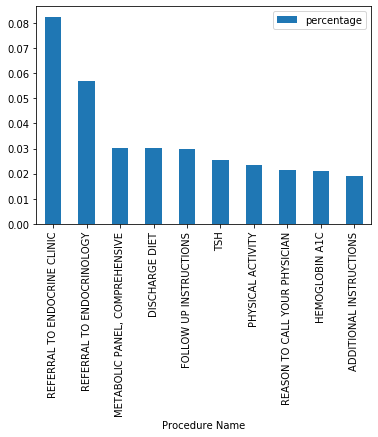

In [3]:
df= df_n
lendf = df.shape[0]
df_plot = df['proc_name'].value_counts().head(10).reset_index().rename(columns={'index':'Procedure Name','proc_name':'percentage' })
df_plot['percentage' ]=df_plot['percentage' ]/lendf
df_plot.plot.bar(x='Procedure Name',y='percentage' )

### Remove unnecessary columns and rows

In [11]:
print(df_all.head())

# only take PC_enc and proc_id
df = df_all[['PC_enc', 'proc_id']]

# remove duplicate rows:
df = df.drop_duplicates()

print(df.head())

     jc_uid    PC_enc     PC_app_datetime     PC_ref_datetime    SP_enc  \
0  JCde3c18  15485327 2008-05-11 08:30:00 2008-05-11 09:03:00  15831299   
1  JCde3c18  15485327 2008-05-11 08:30:00 2008-05-11 09:03:00  15831299   
2  JCde3c18  15485327 2008-05-11 08:30:00 2008-05-11 09:03:00  15831299   
3  JCde3c18  15485327 2008-05-11 08:30:00 2008-05-11 09:03:00  15831299   
4  JCe28c64  15495377 2008-05-12 00:00:00 2008-05-12 18:05:00  15574109   

      SP_app_datetime           order_type  proc_id  \
0 2008-06-22 10:00:00  Outpatient Referral    34378   
1 2008-06-22 10:00:00  Outpatient Referral    34378   
2 2008-06-22 10:00:00            Pathology   152948   
3 2008-06-22 10:00:00            Pathology   152948   
4 2008-05-26 10:00:00  Outpatient Referral    34378   

                           proc_name     proc_order_time  
0          REFERRAL TO ENDOCRINOLOGY 2008-05-11 09:03:00  
1          REFERRAL TO ENDOCRINOLOGY 2008-05-11 09:03:00  
2  GYN CYTOLOGY - PAP SMEAR SPECIMEN 2008

### Create the table of unique encounter id

In [12]:
unq_PC_enc = df.groupby(['PC_enc']).apply(len).reset_index().rename(columns={'proc_id':'proc_id', 0:'num_unq_proc'}).sort_values('num_unq_proc',ascending=False)  
print(unq_PC_enc.head())
print('All of the encounters with at least one proc order: ',len(unq_PC_enc))
print('Average order per encounter: ', np.mean(unq_PC_enc.num_unq_proc.to_numpy()))
print('Min order per encounter: ', np.min(unq_PC_enc.num_unq_proc.to_numpy()))
print('Max order per encounter: ', np.max(unq_PC_enc.num_unq_proc.to_numpy()))

             PC_enc  num_unq_proc
11376  131254053493            45
7011   131194225005            45
4809   131058257208            39
1890   131016182730            37
11024  131251209104            37
All of the encounters with at least one proc order:  12067
Average order per encounter:  3.7045661722051877
Min order per encounter:  1
Max order per encounter:  45


### Choose only specific proc names

In [13]:

Top_proc_names = [ 'TSH', 'T4','25-HYDROXYVITAMIN','1 25 OH VITAMIN D','METABOLIC PANEL','HEMOGLOBIN','PARATHYROID','CORTISOL' ,'TPO AB','PHOSPHORUS',
            'CREATININE','PROLACTIN','US THYROID','CALCIUM','FSH','T3','ADRENOCORTICOTROPIC','LIPID PANEL','LUTEINIZING',
            'BONE ALKALINE','IGA','PEPTIDE','DXA ADULT','TESTOSTERONE','HGB','MAGNESIUM','IMMUNOGLOBULIN','COLLAGEN TYPE',
            'ALBUMIN', 'THYROGLOBULIN','VITAMIN B12','CBC','DEHYDROEPIANDROSTERONE','ESTRADIOL','BONE DENSITY','INSULIN-LIKE GROWTH FACTOR 1',
            'METANEPHRINES','ALDOSTERONE','HEPATIC','THYROGLOBULIN','US HEAD NECK SOFT TISSUE','URINE PROTEIN','RENIN','ALT',
            'FERRITIN','NTX TELOPEPTIDE','PROTEIN IMMUNOFIX ELECTROPHORESIS','CELIAC DISEASE SCREEN','NON-GYN CYTOLOGY EXAM','URIC ACID',
            'AST','T-TRANSGLUTAMINASE','GAD','17OH PROG','FRUCTOSAMINE','SEX HORMONE BINDING GLOBULIN','SURVEY FOR METASTATIC THYROID CANCER',
            'CATECHOLAMINES','NUC 131I WHOLE BODY POST THERAPY SCAN', 'GLUCOSE NON-FASTING','TRANSFERRIN SATURATION']


N_proc = len(Top_proc_names)
print(N_proc)
                  
                  

61


### Create Feature Matrix of Lab Results

In [14]:
import sys

for i in range(N_proc):
    
    # define the search function
    def my_func(df):
        return int(len(df[df['proc_name'].str.contains(Top_proc_names[i])])>0)
    
    #def my_func(df):
    #    return int(len(df[df['proc_name'].str.contains(Top_proc_names[i])])>0)
    
    F_df = df_n.groupby(['PC_enc']).apply(my_func).reset_index().rename(columns={'PC_enc':'PC_enc', 0:'F'+str(i)}) 
    unq_PC_enc = pd.merge(unq_PC_enc, F_df, how='left', on='PC_enc')
    
    # report i 
    sys.stdout.write('\r')
    sys.stdout.write(str(i/N_proc*100)+'%')
    sys.stdout.flush()


print(unq_PC_enc.head())


98.36065573770492%%         PC_enc  num_unq_proc  F0  F1  F2  F3  F4  F5  F6  F7  ...  F51  F52  \
0  131254053493            45   1   0   0   0   1   1   0   0  ...    0    0   
1  131194225005            45   0   0   1   0   1   0   0   1  ...    0    1   
2  131058257208            39   1   0   0   1   1   0   0   0  ...    0    0   
3  131016182730            37   0   0   0   0   1   0   0   0  ...    0    0   
4  131251209104            37   1   1   0   0   0   1   0   0  ...    0    0   

   F53  F54  F55  F56  F57  F58  F59  F60  
0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    1  
4    0    0    0    0    0    0    0    1  

[5 rows x 63 columns]


### Save the Results into CSV

In [15]:
print(len(unq_PC_enc))
#print(unq_PC_enc.sort_values('F0',ascending=False))
#print(np.sum(unq_PC_enc['F0'].to_numpy()))
unq_PC_enc.to_csv('PC_proc.csv', index=False)

12067
